In [2]:
# Notebook for our experiemnt on slabs
"""The value of index n can be extracted by comparing the M(theta) data with functional shapes 
computed for a set of candidate n-values."""

'The value of index n can be extracted by comparing the M(theta) data with functional shapes \ncomputed for a set of candidate n-values.'

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [8]:
T = 1e-3 # thickness of slab in mm
n = 1.5 # guess of index of refraction
lambda_HeNe = 633e-9 # wavelength of laser in nm (vacuum)

In [20]:
# Defining functions we will use later

def get_n(theta, M, T):
    """Function to get index of refraction; from TeachSpin article Chap 11-5"""
    
    alpha = (M * lambda_HeNe)/ (2*T)
    n = ((alpha**2) + 2*(1 - np.cos(theta))*(1-alpha)) / (2*(1 - np.cos(theta) - alpha))
    return n
    
def getM(theta, n, T):
    """Function to get the fringe count M as a function of theta
        function shape depends on thickness T and index of refraction of the slab"""
    M = (2 * T * (n-1) * (theta **2))/lambda_HeNe
    
    return M

def linearFitPlot(x,y):
    # Fitting the curves
    fitCoeffs, fitCovariances = curve_fit(linModel, x, y)

    # Pick out the best-fit for the 'm' value and best-fit for the 'b' value
    bestfit_m = fitCoeffs[0] # This slope is related to coeff of thermal expansion
    bestfit_b = fitCoeffs[1]

    # Printing best-fit values to screen, bestfit_m is slope of linear fit, b is y-intercept
    print(f'best-fit value for \'m\': {bestfit_m}')
    print(f'best-fit value for \'b\': {bestfit_b}')
    
    bestfit_x = np.arange(np.max(x))
#     Define the y-values for the best-fit line, using the linModel function defined above
    bestfit_y = linModel(bestfit_x, bestfit_m, bestfit_b)
    
    # Plot your data (again) as red circles with error bars
    f,ax = plt.subplots(figsize=(8,5))
    ax.scatter(x, y, c = 'r')
    ax.set_xlabel("$\theta$", fontsize = 16)
    ax.set_ylabel("Counts, M", fontsize = 16)
    
def quadModel(x,a,b):
#     fucntion to return a quadratic fit: ax**2 + b
    return a*(x**2) + b


In [12]:
M = getM(0.5,n,T)

394.9447077409163

In [14]:
# Will want to plot M (fringe counts) versus theta (n should be fit param from the slope)

In [59]:
# Reading in first of our data files
path= '/Users/andrewbowen/OpticsLab/Interferometry/slabs/data/'
data = pd.read_csv(path + 'slab-Index-of-Refraction.csv', header=0)
data['Counts (M)'][1:6] = [x - 100000 for x in data['Counts (M)'][1:6]]
# data['new counts'] = [x[i] + x[i-1] for x,i in enumerate(data['Counts (M)'])]

new_counts = []
c=0
for index,row in data.iterrows():
    
    c += row['Counts (M)']
    new_counts.append(c)
    
data['new counts'] = new_counts
data

,theta (deg),theta_err (deg),Counts (M),new counts
0,0,2,0,0
1,5,2,-11,-11
2,10,2,-36,-47
3,15,2,-54,-101
4,20,2,-53,-154
5,25,2,-190,-344
6,30,2,74,-270
7,35,2,154,-116
8,40,2,64,-52


In [83]:
theta = data['theta (deg)'][0:6]
theta_err = data['theta_err (deg)']
counts = data['new counts'][0:6]

fitCoeffs, fitCovariances = curve_fit(quadModel, theta, counts)

In [84]:
# Bestfit params for our quadratic
bestfit_a = fitCoeffs[0]
bestfit_b = fitCoeffs[1]


theta_input = np.arange(np.max(theta) +2)
quad = quadModel(theta_input, bestfit_a, bestfit_b) # array of model quadratic, to plot later
print(quad)

[   9.21621622    8.69818182    7.14407862    4.55390663    0.92766585
   -3.73464373   -9.43302211  -16.16746929  -23.93798526  -32.74457002
  -42.58722359  -53.46594595  -65.3807371   -78.33159705  -92.3185258
 -107.34152334 -123.40058968 -140.49572482 -158.62692875 -177.79420148
 -197.997543   -219.23695332 -241.51243243 -264.82398035 -289.17159705
 -314.55528256 -340.97503686]


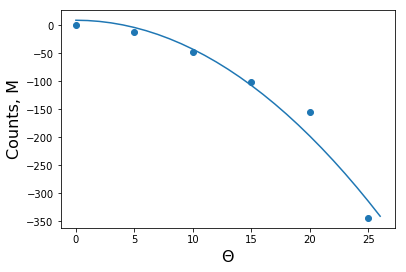

In [85]:
# Plotting counts versus theta (angle relative to start)
f,ax = plt.subplots()
ax.scatter(theta, counts)
ax.set_xlabel('$\Theta$', fontsize = 16)
ax.set_ylabel('Counts, M',fontsize = 16)

# Also plotting our quadratic fit calculated above
ax.plot(theta_input, quad)

In [88]:
n = get_n(theta, counts, 0.5e-3)

n_avg = np.mean(n)
print(n_avg)

0.8279550262520055
